In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
from PIL import Image
import urllib, cStringIO
import cv2
def to_pil(img):
    return Image.fromarray(np.clip(img * 255, 0, 255).astype(np.uint8))

In [2]:
BATCH_SIZE = 64
MODE = 'EVAL' # TRAIN/EVAL

In [3]:
attr_file = '../data/celeba/list_attr_celeba.txt'
keys = None
attributes_by_image = {}
for i, line in enumerate(open(attr_file)):
    if i == 1:
        keys = line.split()
    elif i > 1:
        image = os.path.join('../data/celeba/img_align_celeba', line.split()[0])
        values = line.split()[1:]
        attributes_by_image[image] = {attr: val == '1' for attr, val in zip(keys, values)}


In [4]:
# print keys
image_names = attributes_by_image.keys()
attr_vector = np.zeros((len(attributes_by_image), len(keys)))
for i, image_name in enumerate(image_names):
    attrs = attributes_by_image[image_name]
    attr_vector[i] = [(1 if attrs[key] else 0) for key in keys]

from collections import defaultdict
key_value_pair_counts = defaultdict(int)
for attrs in attributes_by_image.itervalues():
    for pair in attrs.iteritems():
        key_value_pair_counts[pair] += 1
n_images = float(len(image_names))

rarity_vector = np.zeros((len(attributes_by_image), len(keys)))
for i, image_name in enumerate(image_names):
    attrs = attributes_by_image[image_name]
    rarity_vector[i] = [n_images / key_value_pair_counts[(key, attrs[key])] for key in keys]

In [12]:
print keys

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [5]:
# filename_queue = tf.train.string_input_producer(image_names, num_epochs=None)
# attr_queue = tf.train.input_producer(tf.constant(attr_vector), num_epochs=None)

def create_qs(train):
    filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    attr_tensor = tf.convert_to_tensor(attr_vector, dtype=tf.float32)
    rarity_tensor = tf.convert_to_tensor(rarity_vector, dtype=tf.float32)
    filename_q, attr_q, rarity_q = tf.train.slice_input_producer([filename_tensor, attr_tensor, rarity_tensor], num_epochs=None, shuffle=True)

    # reader = tf.WholeFileReader()
    # filename, image_data = reader.read(filename_q)
    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.reshape(tf.cast(image_255, tf.float32) / 255.0, [218, 178, 3]) # images are 178x218


    def resize_image(image):
        image = tf.random_crop(image, [192, 160, 3])
        return image
    #     image = tf.image.resize_bilinear(img_reshaped, [192, 160])
    #     return tf.reshape(image, [192, 160, 3])
    image = resize_image(image)

    def distort_image(image):
        noise_amt = tf.abs(tf.random_normal([], stddev=0.2))
        distorted_image = image + tf.random_uniform([192, 160, 3], maxval=noise_amt)
        distorted_image = tf.image.random_flip_left_right(distorted_image)
        distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3)
        distorted_image = tf.image.random_contrast(distorted_image, lower=0.6, upper=1.6)
        distorted_image = tf.image.per_image_standardization(distorted_image)
        # distorted_image = tf.clip_by_value(distorted_image, 0, 1)
        return distorted_image

    image = distort_image(image) if train else image

    if train:
        images_batch, attrs_batch, rarity_batch = tf.train.shuffle_batch([image, attr_q, rarity_q], batch_size=BATCH_SIZE, capacity=BATCH_SIZE, min_after_dequeue=0)
    else:
        images_batch, attrs_batch, rarity_batch = tf.train.batch([image, attr_q, rarity_q], batch_size=BATCH_SIZE, allow_smaller_final_batch=True)
    return images_batch, attrs_batch, rarity_batch

images_batch, attrs_batch, rarity_batch = create_qs(True)
# images_batch_eval, attrs_batch_eval = create_qs(False)

In [6]:
session = tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
tf.train.start_queue_runners(sess=session)

[<Thread(Thread-4, started daemon 139739596297984)>,
 <Thread(Thread-5, started daemon 139739335362304)>]

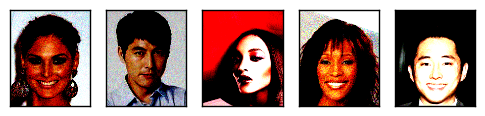

In [7]:
%matplotlib inline

images_, attrs_, rarity_ = session.run([images_batch, attrs_batch, rarity_batch])

imshow_multi(images_[:5])
# for k, val in zip(keys, attrs_[0]):
#     print k, val

In [8]:
dropout_keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='dropout_keep_prob')        
from tensorflow.contrib.layers.python.layers import batch_norm

keyed_vars = {}
def join_keys(key1, key2):
    if key1 is None or key2 is None:
        return None
    else:
        return key1 + '.' + key2

def weight_var(shape, stddev=0.1, mean=0.0, weight_decay=0, name=None, key=None):
    initial = tf.truncated_normal(shape, mean=mean, stddev=stddev)
    v = tf.Variable(initial, name=name)
    if weight_decay > 0:
        l2 = tf.nn.l2_loss(v) * weight_decay
        tf.add_to_collection('losses', l2)
    if key: keyed_vars[key] = v
    return v

def create_fc(input, out_size, relu=True, key=None):
    # input_dropped = tf.nn.dropout(input, dropout_keep_prob)
    in_size = input.get_shape()[-1].value
    w = weight_var([in_size, out_size], name='w', key=join_keys(key, 'w'))
    b = weight_var([out_size], mean=0.1, name='b', key=join_keys(key, 'b'))
    x = tf.matmul(input, w)
    return tf.nn.relu(x + b) if relu else x + b

def create_conv(input, out_channels, patch_size=5, stride=1, dropout=False, key=None):
    in_channels = input.get_shape()[-1].value
    w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
    b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
    conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
    activation = tf.nn.relu(conv + b)
    if dropout: activation = create_dropout(activation)
    return activation

def create_max_pool(inputs, ksize=2, stride=2):
    return tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_avg_pool(inputs, ksize=2, stride=2):
    return tf.nn.avg_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_batch_norm(inputs):
    return batch_norm(inputs, is_training=(MODE == 'TRAIN'), updates_collections=None)

def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

def flatten_tensor(t):
    shape = [s.value for s in t.get_shape()]
    flat_size = 1
    for x in shape[1:]:
        flat_size *= x
    return tf.reshape(t, [-1, flat_size])

In [9]:

def facenetwide(image):
    # size: 192, 160, 3
    # 64 -> 32 -> 16 -> 8 -> 4
    image = tf.image.resize_bilinear(image, [64, 64])
    for i, size in enumerate([16, 32, 64, 64]):
        key = 'conv' + str(i)
        image = create_conv(image, size, patch_size=5, key=key)
        # image = create_batch_norm(image)
        debug_outputs.append(image)
        image = create_avg_pool(image)
        debug_outputs.append(image)
    # now we have a 4x4x64 image:
    image = create_dropout(image)
    image = create_fc(flatten_tensor(image), 256, key='fc1')
    debug_outputs.append(image)
    image = create_fc(image, 256, key='fc2')
    debug_outputs.append(image)
    return create_fc(image, len(keys), relu=False, key='fc3')

image_input = tf.placeholder_with_default(images_batch, [None, 192, 160, 3], name='image_input')
actual_attrs = tf.placeholder_with_default(attrs_batch, [None, len(keys)], name='actual_attrs')
rarities = tf.placeholder_with_default(rarity_batch, [None, len(keys)], name='rarities')

attr_logits = facenetwide(image_input)
attr_predictions = tf.sigmoid(attr_logits)

In [10]:
loss_by_attr = tf.nn.sigmoid_cross_entropy_with_logits(attr_logits, actual_attrs) * rarities
loss = tf.reduce_sum(loss_by_attr)

learn_rate = tf.placeholder_with_default(tf.constant(0.001), [], name='learn_rate')
optimizer = tf.train.AdamOptimizer(learn_rate)
global_step = global_step = tf.contrib.framework.get_or_create_global_step()
train_step = optimizer.minimize(loss, global_step=global_step)

correct_vals = tf.cast(tf.equal(tf.round(actual_attrs), tf.round(attr_predictions)), tf.float32)
# correct_counts = tf.reduce_sum(tf.cast(tf.equal(tf.round(actual_attrs), tf.round(attr_predictions)), tf.float32), axis=0)
scaled_correctness = correct_vals * rarities
scaled_correctness_avg = tf.reduce_mean(scaled_correctness, axis=0) / tf.reduce_mean(rarities, axis=0)




In [11]:
save_path = 'models/facenet-wide'

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)

saver = None
if save_path:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(save_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(session, ckpt.model_checkpoint_path)
        print 'Restored from checkpoint', ckpt.model_checkpoint_path
    else:
        print 'Did not restore from checkpoint'
else:
    print 'Will not save progress'

Restored from checkpoint models/facenet-wide/model.ckpt-12500


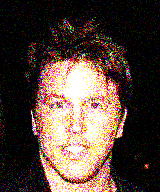

In [127]:
def find_matching_user(attrs):
    while True:
        faces, attr_vecs = session.run([images_batch, attrs_batch])
        for face, vec in zip(faces, attr_vecs):
            match = True
            for key, val in attrs.iteritems():
                if (1 if vec[keys.index(key)] else 0) != (1 if val else 0):
                    match = False
            if match:
                return face

m = find_matching_user({"Bald": False})
m_orig = m.copy()
to_pil(m)

In [132]:
info = session.run(attr_predictions, {image_input: [m]})[0]
info[keys.index('Bald')]

0.90162438

In [129]:
target_val = 1
transform_loss = tf.nn.l2_loss(attr_predictions[0][keys.index('Bald')] - target_val)
grad = tf.gradients(transform_loss, [image_input])[0]

In [130]:
diff_image = np.zeros_like(m)
for _ in xrange(5 * 1000):
    diff = session.run(grad, {image_input: [m]})[0]
    m -= diff * 0.1
    diff_image -= diff * 0.1

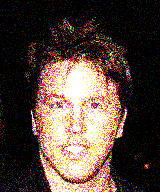

In [131]:
to_pil(m)

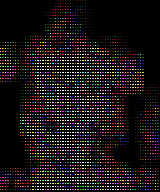

In [138]:
to_pil(np.abs(m - m_orig) * 50)